# Контекст

- GLM модель с нуля
- на тексте Война и Мир Л.Н. Толтого


In [1]:
import pandas as pd
from tokenizers.processors import TemplateProcessing
from tokenizers import Tokenizer
from tokenizers.normalizers import (Sequence,Lowercase, NFD, StripAccents)
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE
from tokenizers.decoders import WordPiece as WordPieceDecoder

import re
import os


# Создание объекта токенизатора

In [2]:
with open('Tolstoy_Lev_Voyna_i_mir_1-2.txt', 'r') as file:
    file1 = file.readlines()

with open('Tolstoy_Lev_Voyna_i_mir_3-4.txt', 'r') as file:
    file2 = file.readlines()



def cleaner(text_line):
    clean_text = text_line.encode('utf-8')
    clean_text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9\.\,\!\?\:\;\"\'\(\)\-\s]', '', text_line)
    clean_text = re.sub(r'[\n\r\t\\]', '', clean_text)
    clean_text = clean_text.strip()
    return clean_text


clean_spisok_text = []
for file in (file1, file2):
    for text_line in file:
        clean_line = cleaner(text_line)
        clean_spisok_text.append(clean_line)

In [3]:
len(clean_spisok_text)

13203

In [4]:
tokenizer = Tokenizer(BPE())
tokenizer.normalizer = Sequence(
                                [NFD(), # нормализатор Unicode
                                 Lowercase(), # нижний регистр
                                 StripAccents()] # удаление доп. буквенных символов (напрмер волну над буквами в турецком языке)
                            )
tokenizer.pre_tokenizer = Whitespace() # разбиение на пробелы
# tokenizer.decoder = BPEDecoder() # совместимый с BPE декодер
tokenizer.decoder = WordPieceDecoder()

trainer = BpeTrainer(
    vocab_size = 30000,
    special_tokens = [
        '<s>',
        '<pad>',
        '<\s>',
        '<unk>',
        '<mask>'
    ]
)

tokenizer.train_from_iterator(clean_spisok_text, trainer = trainer)

In [5]:
len(tokenizer.get_vocab())

30000

In [6]:
# сохранение токенизатора
tokenizer.save('tokenizer_gpt/tokenizer.json')

In [7]:
tokenizer.decode(tokenizer.encode('Я пошел гулять').ids)

'я пошел гулять'

In [8]:
from transformers import (GPT2TokenizerFast, GPT2Config, GPT2LMHeadModel)


tokenizer_gpt = GPT2TokenizerFast.from_pretrained('tokenizer_gpt')
tokenizer_gpt.add_special_tokens({
                        "eos_token": "</s>",
                        "bos_token": "<s>",
                        "unk_token": "<unk>",
                        "pad_token": "<pad>",
                        "mask_token": "<mask>"
})

len(tokenizer_gpt.get_vocab())

file tokenizer_gpt\config.json not found
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


30002

In [9]:
tokenizer_gpt.encode("<s> Я пошел гулять </s>")

[0, 80, 1259, 24832, 30001]

# Скачиваем архитектуру модели GPT-2

In [10]:
config = GPT2Config(
        vocab_size = tokenizer_gpt.vocab_size,
        bos_token_id = tokenizer_gpt.bos_token_id,
        eos_token_id = tokenizer_gpt.eos_token_id
)
model = GPT2LMHeadModel(config)
config

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 30001,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.16.2",
  "use_cache": true,
  "vocab_size": 30000
}

# Подготовка текстового корпуса к обучению

In [11]:
content = []

for text_line in clean_spisok_text:
    clean_line = text_line.replace('\xa0', '')
    if len(clean_line) > 10: # оставляем длинные строки, для генерации более длинных последовательностей
        content.append(clean_line.strip())

content = ' '.join(content) + tokenizer_gpt.eos_token # добавляем токен </s> для работы с длинными последовательностями
                                                      # можно было ставить </s> в конце каждой строки,
                                                      # но модель будет постоянно с ним сталкиваться что может повлиять
                                                      # на длину последовательности вывода

In [12]:
tokenized_content = tokenizer_gpt.encode(content)
len(tokenized_content)

613618

In [13]:
# подготовим строки, каждая длиной = 100 с наложением
# т.е. [Я пошел гулять в парк у реки ......] len = 100
#      [пошел гулять в парк у реки.........] len = 100
#      [гулять в парк у реки...............] len = 100

sample_len = 100
examples = []
for i in range(0, len(tokenized_content)):
    examples.append(tokenized_content[i:i + sample_len])

print(examples[:4])

[[22898, 459, 1268, 25838, 15688, 3100, 13157, 29544, 26971, 13083, 8624, 2527, 58, 2061, 10, 14051, 12, 52, 5230, 4018, 1178, 58, 3823, 26327, 15084, 2527, 58, 2061, 1007, 152, 2262, 23916, 4954, 243, 21183, 7683, 6536, 8995, 10, 45, 13, 10, 11, 27144, 25872, 9, 17579, 11448, 152, 25522, 462, 12122, 148, 6, 25915, 13138, 7, 2128, 4311, 4358, 2318, 8, 902, 3407, 10, 3121, 373, 585, 9473, 25841, 410, 4165, 2354, 638, 1386, 4839, 423, 13140, 8, 1386, 2181, 1741, 8, 301, 502, 20552, 13089, 10, 3582, 8, 811, 668, 1466, 15691, 638, 786, 668, 410, 636, 4542], [459, 1268, 25838, 15688, 3100, 13157, 29544, 26971, 13083, 8624, 2527, 58, 2061, 10, 14051, 12, 52, 5230, 4018, 1178, 58, 3823, 26327, 15084, 2527, 58, 2061, 1007, 152, 2262, 23916, 4954, 243, 21183, 7683, 6536, 8995, 10, 45, 13, 10, 11, 27144, 25872, 9, 17579, 11448, 152, 25522, 462, 12122, 148, 6, 25915, 13138, 7, 2128, 4311, 4358, 2318, 8, 902, 3407, 10, 3121, 373, 585, 9473, 25841, 410, 4165, 2354, 638, 1386, 4839, 423, 13140, 8, 1

In [14]:
# Разбиваем подготовленные строки на input и labels
# train = [Я пошел гулять в]
# label = [пошел гулять в парк] и так с каждой подготовленной строкой длиной 100 строкой
train_data = []
labels = []
for example in examples:
    train_data.append(example[:-1])
    labels.append(example[1:])

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

class  TolstoyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {'input_ids': torch.tensor(self.data[idx]),
                'labels': torch.tensor(self.labels[idx])}

dataset = TolstoyDataset(train_data[:10000], labels[:10000])

data_loader = DataLoader(
    dataset = dataset,
    batch_size = 32,
    shuffle = False,
    drop_last = True
)

CUDA ?:  True
Расчетное время выполнения всего цикла 17.315 минут
Epoch     1/   10 || time: 103.890 || train loss: 7.958 || train accuracy: 0.104 
Epoch     2/   10 || time: 97.707 || train loss: 6.621 || train accuracy: 0.116 
Epoch     3/   10 || time: 150.068 || train loss: 6.153 || train accuracy: 0.130 
Epoch     4/   10 || time: 124.010 || train loss: 5.696 || train accuracy: 0.155 
Epoch     5/   10 || time: 130.347 || train loss: 5.225 || train accuracy: 0.191 
Epoch     6/   10 || time: 130.344 || train loss: 4.704 || train accuracy: 0.231 
Epoch     7/   10 || time: 130.658 || train loss: 4.158 || train accuracy: 0.287 
Epoch     8/   10 || time: 132.013 || train loss: 3.612 || train accuracy: 0.372 
Epoch     9/   10 || time: 129.675 || train loss: 3.082 || train accuracy: 0.459 
Epoch    10/   10 || time: 121.648 || train loss: 2.574 || train accuracy: 0.527 


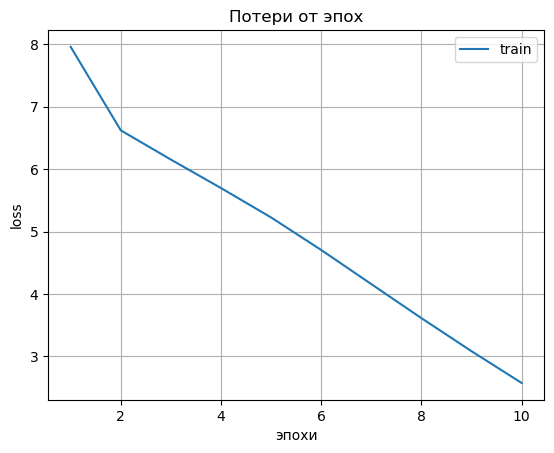

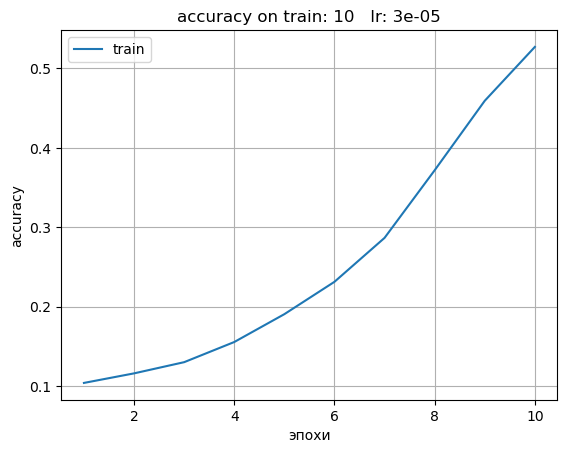

In [16]:
from loop_functions import *
import torch
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr = 3e-5, eps = 1e-8)
loss_fn = nn.CrossEntropyLoss()


model =\
training_loop(
    epoches = 10,
    model = model,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_dataloader = data_loader,
    regulizer_append = False,
    reg_type = None,
    verbose_epoch = 1
)

# Использование обученной модели

In [17]:
def generate(start, model, max_length):
    input_token_ids = tokenizer_gpt.encode(start, return_tensors = 'pt')
    model = model.cpu()
    outputs = model.generate(
        input_token_ids,
        max_length = max_length,
        num_beams = 5,
        temperature = 0.7,
        no_repeat_ngram_size = 2,
        num_return_sequences = 1
    )
    return tokenizer_gpt.decode(outputs[0])



generate('Добрый вечер !', model, 100)

Setting `pad_token_id` to `eos_token_id`:30001 for open-end generation.


'добрыи вечер! князь андреи по - русски к маленькои княгине и, обернул оживленное лицо к князю ипполиту, так же, как у князя андрея в карету с полки книгу ( это были записки це заря ) он был рассеян. князь ипполит фыркнул еще и стал надевать ее оправля л саблю ; но только затем, что - то говорить по привычке, вечныи мир! mon cher, сказал виконт. et tout а вы готовы? сказала анна павловна и сквозь смех проговорил : et vous au revoir, сказала она зате вала между анатолем'

In [18]:
generate('Сегодня', model, 30)

Setting `pad_token_id` to `eos_token_id`:30001 for open-end generation.


'сегодня в карету. князь андреи по - русски к князю ипполиту, так же, как у князя андрея глаза были записки це заря ) и махнул рукои.'

# Сохранение модели

In [19]:
model.save_pretrained("GPT-2-TolstoyEdition/")
model_reloaded = GPT2LMHeadModel.from_pretrained("GPT-2-TolstoyEdition/")

# Втроенная функция генерации текста

In [ ]:
from transformers import pipeline

text_genaration = pipeline('text-generation', model = model, tokenizer = tokenizer_gpt)
prefix = 'Я пошел гулять'
generated_text = text_genaration(prefix, max_length = 500)

In [21]:
generated_text[0]['generated_text']

'Я пошел гулять. князь ипполит, так же, так что - русски к князю ипполиту, но только не правда, но только не мог разобрать этого ) он был рассеян. я очень рад, как будто обнимал молодую женщину. я очень рад, но только не так же, но только не мог этого ) он, но только не политическим равнове си ем. я очень рад, но только не мог этого ) он был рассеян. князь андреи не правда, но только не так что - нибудь особенно приятное. князь андреи и, но только не все улыбаясь, но только не умею, но только не правда, но только не так что не так что - vous vous vous vous vous vous vous, но только не так же, но только не политическим равнове си ем, но только не так же, но только не так же, но только не так же, но все и, но только не политическим равнове си ем. князь андреи не политическим равнове си ем, но только не так что - то, но только не политическим еще, но только что все, но не так он не все, но не так он был рассеян. et vous? спросил он, но только не так что не правда, но только что не так что